### Notes
The Fresnel Transfer Function (TF) Propagator is given by the equation (CFO 5.2):
$$
H(f_x, f_y) = e^{j k z} \exp[- j \pi \lambda z (f_x^2 + f_y^2)]
$$

The focus transmittance function is approximately (CFO 6.9):
$$
t_{A}(x, y) = \exp[-j \frac{k}{2 z_f} \left(x^2 + y^2 \right)]
$$

### Incoherent Imaging

To test, we will start with a square pupil function (CFO 7.8)
$$
P(x, y) = \text{rect}\left(\frac{x}{2 w_{\text{XP}}}\right) \text{rect}\left(\frac{y}{2 w_{\text{XP}}}\right)
$$
The coherent transfer function is (CFO 7.9):
$$
H(f_U, f_V) = \text{rect}\left(\frac{-\lambda z_{\text{XP}} f_U}{2 w_{\text{XP}}} \right)
\text{rect}\left(\frac{-\lambda z_{\text{XP}} f_V}{2 w_{\text{XP}}} \right)
$$

### Bench Measurments
The f-number of a lens is the focal length divided by aperture diameter:
* 50mm Lens:  $f/\# = 2.0$
* 400mm Lens: $f/\# = 16.0$

From CFO section 7.2.3 the constraint on length $L$ given a number of samples $M$ is (CFO 7.19):
$$
L \leq M \frac{\lambda(f/\#)}{2}
$$

For the above lenses with a 490nm wavelength LED and a 500x500 pixel image, this means:
* 50 mm Lens: $L \leq 2.45 \cdot 10^{-4} \text{m}$
* 400 mm Lens: $L \leq 1.96 \cdot 10^{-3} \text{m}$

These measurements are approximations of how small L can be (in the object plane F1 & F2) before we see sampling artifacts.

### TODO LIST

* Change Pupil Function to circular ~2.5cm
* Reduce L to be accurate to plane F1 & F2 (NOT the size of our lenses ~2.5cm)
* Read Rosen Papers and simulate with their measurements, since we know it works.

In [1]:
import numpy as np
import numpy.fft as fft #shorthand for fft.fft2 and fft.fftshift
from dataclasses import dataclass 
#import poppy #optical simulation library: not as many uses as I hoped, more for telescope simulation
import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1 import make_axes_locatable #for making nice colorbars

In [14]:
@dataclass
class image_plane:
    #dataclass representing a 2D image plane with a label
    #simplifies plotting, labeling, and propagating images
    image: np.ndarray
    label: str
    length: float = 2.0 #assuming image axes from (-L/2, L/2)
    
    def plot(self, fig=None, ax=None, bounds="auto", label=None, savefig=False, show=True, plot_type="intensity"):
        if ax is None:
            plt.figure("{}".format(self.label), figsize=(7,7))
            ax = plt.gca()
        if fig is None:
            fig = plt.gcf()
        divider = make_axes_locatable(ax)
        plot_args = {'cmap':'gray', 'extent':[-0.5*self.length, 0.5*self.length, -0.5*self.length, 0.5*self.length]}
        if bounds.lower()=='full':
            plot_args['vmin'] = 0.
            plot_args['vmax'] = 1.
            tick_values = [0, 0.5, 1]
        else:
            tick_values = None
        if plot_type.lower() == "intensity":
            plot_vals = np.abs(self.image)**2
        elif plot_type.lower() == "real":
            plot_vals = np.real(self.image)
        elif plot_type.lower() == "imag":
            plot_vals = np.imag(self.image)
        im = ax.imshow(plot_vals, **plot_args)
        ax.set_title(self.label)
        cax = divider.append_axes('right', size='5%', pad=0.05)
        fig.colorbar(im, cax=cax, orientation='vertical', ticks=tick_values)
        label = self.label if label is None else label
        if savefig:
            plt.savefig("./Images/{}.png".format(label))
        if show:
            plt.draw()

    def zoom(self):
        sample_density = self.image.shape[0]
        midpoint = sample_density // 2
        buffer = sample_density // 40
        line_samples = [midpoint, midpoint + buffer, midpoint - buffer]
        bound = 0
        #iterate over a few lines to reduce chance of overcropping
        for line_num in line_samples:
            vert_line = self.image[line_num,:]
            horiz_line = self.image[:,line_num]
            vert_threshold = np.max(vert_line) / 20
            horiz_threshold = np.max(horiz_line) / 20
            #boundary should be the largest index that can be seen that doesn't contain a significant percent of the image intensity.
            bound = max([bound, np.argmax(vert_line > vert_threshold), np.argmax(horiz_line > horiz_threshold)])
        if bound > buffer:
            cropped_im = self.image[bound-buffer:-1*(bound-buffer), (bound-buffer):-1*(bound-buffer)]
        else:
            print("Could not crop image.")
            return self
        reduced_length = (sample_density - 2*bound) / (sample_density) * self.length
        return image_plane(cropped_im, "{} (Cropped)".format(self.label), length=reduced_length)
    
    def __add__(self, other):
        assert(self.length == other.length)
        return image_plane(self.image + other.image, "{} + {}".format(self.label, other.label), self.length)
    

#Plotting Functions
def plot_images(im_list, bounds="auto", plot_type="intensity"):
    num_ims = len(im_list)
    fig, ax = plt.subplots(1, num_ims, figsize = (15, 15*num_ims))
    for idx, im in enumerate(im_list):
        im.plot(fig, ax[idx], bounds=bounds, savefig=False, show=False, plot_type=plot_type)
    plt.show()

In [30]:
#Functions for propagating images
def point_distribution(sample_density=100, length=1.):
    #create a uniform distribution of (sample_density^2) 2D coordinates
    return np.array(np.meshgrid(np.linspace(-1*length/2, length/2, sample_density), np.linspace(-1*length/2, length/2, sample_density)))

def fresnel_TF_prop(U1, L, z, wavelength=1, label=None):
    # simulate the optical propagation of an input plane based on the Frenel Transfer Function
    #based on CFO p63
    #U1: Input image plane object, a set of coordinates that will be propagated
    #z: propagation distance
    #L: length of one side of source and observation plane
    sample_density = U1.image.shape[0]
    dx = L / sample_density
    #k = 2 * np.pi / wavelength
    frequency_coords = np.arange(-1/(2*dx), 1/(2*dx), 1/L) 
    freq_dist = np.array(np.meshgrid(frequency_coords, frequency_coords))
    #freq_dist = 1 / (2* point_distribution(sample_density)) #create frequency sample distribution
    freq_magnitude = np.sum(freq_dist**2, axis=0) 
    TF_arg = -1j * np.pi * wavelength * z * freq_magnitude #argument for the fresnel TF
    H = fft.fftshift(np.exp(TF_arg)) #created shifted transfer function
    U1_fft = fft.fft2(fft.fftshift(U1.image)) #shift & fft input (source) field
    U2 = fft.ifftshift(fft.ifft2(U1_fft * H)) # output (observed) field obtained by multiplying FFT by H
    #set a default label if none specified
    label = "{} (Fresnel Propagated)".format(U1.label) if label is None else label
    return image_plane(U2, label, U1.length)

def pupil_func(U1, lens_radius = 1):
    return np.sqrt(np.sum(U1**2, axis=0)) / lens_radius <= 1

def lens_transmittance_fxn(U1, wavelength, f):
    #CFO examples p96
    k = 2 * np.pi / wavelength
    return pupil_func(U1) * np.exp(-1j * k / (2*f) * np.sum(in_coords**2, axis=0))

def focus(U1, zf, wavelength=1., label=None):
    #focus(+) or defocus(-) an image with a focal length of +/- zf
    #from MATLAB examples p94
    # U1: input (source) image
    # zf: focal length of lens
    uniform_dist = point_distribution(U1.image.shape[0])
    exp_arg = (-1j * np.pi / (zf * wavelength)) * np.sum(uniform_dist**2, axis=0)
    focused = U1.image * np.exp(exp_arg)
    #set a default label if none specified
    label =  "{} (Focused)".format(U1.label) if label is None else label
    return image_plane(focused, label)

def circ(point_grid, radius):
    return np.array(np.sqrt(np.sum(point_grid**2, axis=0)) < radius).astype(float)

def quadratic_phase_prop(point_grid, z, wavelength=1., image_length=1.):
    k = 2 * np.pi / wavelength
    sq_distances = np.sum(point_grid**2, axis=0)
    return np.array(np.exp((-1j * k / (2*z)) * sq_distances))

def ft(image):
    return fft.fft2(fft.fftshift(image), norm="ortho")

def ift(image):
    return fft.ifftshift(fft.ifft2(image, norm="ortho"))

def OTF(U1, L, zxp, wxp, wavelength=1., label=None):
    #generate Optical Transfer Function (CFO 7.24) for simulated imaging
    #based on CFO p129, Goodman p141
    #wxp: exit pupil radius
    #zxp: exit pupil distance
    #L: object plane side length
    assert(U1.image.shape[0] == U1.image.shape[1]) #must be square image
    sample_interval = L / U1.image.shape[0]
    freq_sample_range = np.arange(-1/(2*sample_interval), 1/(2*sample_interval), 1/L)
    freq_sample = np.array(np.meshgrid(freq_sample_range, freq_sample_range))
    f0 = wxp / (wavelength * zxp) #coherent cutoff
    H = circ(freq_sample, f0)
    OTF_result = fft.ifft2(np.abs(fft.fft2(fft.fftshift(H)))**2)
    OTF_result = abs(OTF_result / OTF_result[0,0]) #normalization condition CFO 7.25 (Goodman p138)
    #set a default label if none specified
    label = "{} (OTF)".format(U1.label) if label is None else label
    return image_plane(OTF_result, label, U1.length)

def convolution(U1, U2, label=None):
    assert(U1.length == U2.length)
    G1 = fft.fft2(fft.fftshift(U1.image))
    G2 = fft.fft2(fft.fftshift(U2.image))
    result = fft.ifftshift(fft.ifft2(G1*G2))
    label = "{}*{}".format(U1.label, U2.label) if label is None else label
    return image_plane(result, label, U1.length)

def incoherent_image(U1, L, zxp, wxp, wavelength=1., label=None):
    #simulate an incoherent image based on input image
    #wxp: exit pupil radius
    #zxp: exit pupil distance
    #L: image plane side length
    OTF_result = OTF(U1, L, zxp, wxp, wavelength, label="")
    Ig = U1.image / np.max(U1.image.flatten()) #ideal image
    Gg = fft.fft2(fft.fftshift(Ig)) #FT of ideal image
    Gi = Gg * OTF_result.image #multiplt FTs
    Ii = np.real(fft.ifftshift(fft.ifft2(Gi)))
    Ii *= (Ii > 0) #set negative parts to zero
    #set a default label if none specified
    label = "{} (Incoherent Image)".format(U1.label) if label is None else label
    return image_plane(np.sqrt(Ii), label, U1.length)

In [31]:
#Gaussian Beam in 2D
dist = np.array(np.meshgrid(np.linspace(-1, 1, 500), np.linspace(-1, 1, 500)))
gaus = image_plane(np.exp(-np.sum(dist**2, axis=0)/0.25), "Gaussian")
#square beam in 2D
diamond = image_plane(np.array(np.sum(np.abs(dist), axis=0) < 0.5).astype(float), "Diamond")
sq = image_plane(np.array(
                 np.logical_and(abs(dist[1,:,:]) < np.ones_like(dist[1,:,:])*0.5,
                                abs(dist[0,:,:]) < np.ones_like(dist[0,:,:])*0.5)).astype(float),
                 "Square")        
dot = image_plane(circ(point_distribution(500), 0.3), "Dot")
point = image_plane(circ(point_distribution(500), 0.05), "Point")
const = image_plane(np.ones_like(point_distribution(3000))[0], "Constant")

### Simple Test
To simplify the simulation and work up, I will assume a linear polarizer is in place of of the QWP. Then we can just look at the PSF for a birefringent lens. The linear polarizer will be at 45 degrees with respect to the polarizing beam splitter, so the overall effect is that we will have complete overlap of the two beams in our interferometer. We will generate an ideal image from a point which has projected forward to F1 by a displacement $+d$, along with a second ideal image propagated by $-d$ (backward) to the point F2. These two images will be propegated with `incoherent_image()` to the point IM, and this is our PSF for this birefringent lens.

![alt text](Images/BRL_diagram.png "BRL Diagram")

The simulated image is the convolution of the PSF(dot above) with the ground truth image.
We will want to add in magnification, but that will just be a factor in the denominator of the phase.

### Bench Measurements
Our Triangle Interferometer Measurements are approximately:
* Wavelength $\lambda = 490$ nm
* Object plane side length $L = 2.5$ cm (UPDATE)
* Hologram distance $z = 415$ mm
* Lens Radius $\omega_{xp} = 1.25$ cm
* Object plane images displacement $d = 15$ mm 

The measurements from the BRL setup in the paper are (Brooker):
* Wavelength $\lambda = 465$ nm
* Object plane side length $L = ?$
* Hologram distance $z = 273.73$ mm
* Lens radius $\omega_{xp} = ?$
* Object plane images displacement $d = 10$ mm 

The magnification of the hologram is given by (Brooker):
$$
M = \frac{z_h f_{\text{L1}}}{f_{\text{L2}} f_{\text{L0}}}
$$
Where the lenses L0, L1, and L2 come from figure 3 of Brooker.

In [34]:
@dataclass
class BRL_bench_measurements:
    #dataclass for relevant bench measurements of a bi-refringent lens
    wavelength: float = 490e-9 #490 nm
    length: float = 2.5e-3 #2.5cm (FIX)
    z: float = 415e-3 #415mm
    wxp: float = 1.25e-2 #1.25cm
    displacement: float = 15e-3 #15mm
    num_points: int = 500
    pupil_radius: float = 1.25e-2 #1.25cm
    
    def get_planes(self):
        #start with a point source
        p_grid = point_distribution(self.num_points, 4*self.pupil_radius)
        point = image_plane(circ(p_grid, 1e-3), 
                            "Point", length = 4*self.pupil_radius)
        #propagate a quadratic phase onto the two points to generate F1 & F2 (cite goodman)
        f1 = image_plane(point.image * quadratic_phase_prop(p_grid, self.displacement,
                                                            wavelength=self.wavelength, 
                                                            image_length=point.length), "F1")
        f2 = image_plane(point.image * quadratic_phase_prop(p_grid, -1*self.displacement,
                                                            image_length = point.length,
                                                            wavelength=self.wavelength), "F2")
        #assume pupil function is a circle of radius 1.25cm
        pupil = image_plane(pupil_func(point_distribution(self.num_points), 0.5), 
                            label="Pupil Function", length=4*self.pupil_radius)
        #fouruer transform F1 & F2
        f1_ft = image_plane(ft(f1.image), "F1 (FT)")
        f2_ft = image_plane(ft(f2.image), "F2 (FT)")
        #miltiply FT by the pupil funcction to get the image of each
        f1_im = image_plane(ift(f1_ft.image*pupil.image), "F1 Image", f1.length)
        f2_im = image_plane(ift(f2_ft.image*pupil.image), "F2 Image", f2.length)
        #interference is just the sum of the two
        interference = f1_im + f2_im
        #return all values as a dictionary
        return_dict = {"point":point, "f1":f1, "f2":f2, "pupil":pupil, "f1_ft":f1_ft, "f2_ft":f2_ft,
                       "f1_im":f1_im, "f2_im":f2_im, "interference":interference}
        return return_dict
    
    def default_plot(self):
        planes = self.get_planes()
        plot_images([planes["point"], planes["pupil"]])
        plot_images([planes["f1"].zoom(), planes["f2"].zoom()], plot_type="imag")
        plot_images([planes["f1_ft"], planes["f2_ft"]])
        plot_images([planes["f1_im"].zoom(), planes["f2_im"].zoom()])
        planes["interference"].zoom().zoom().plot()

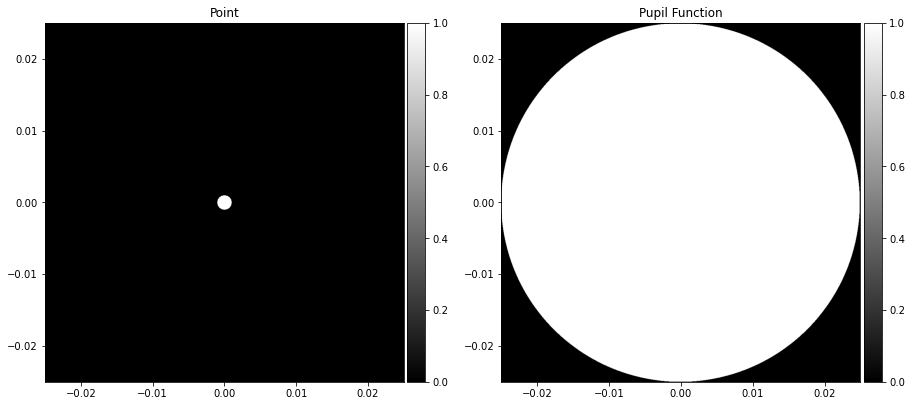

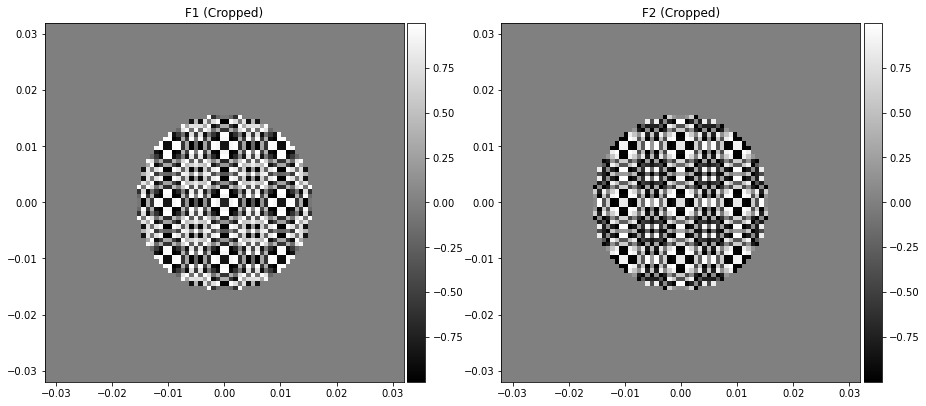

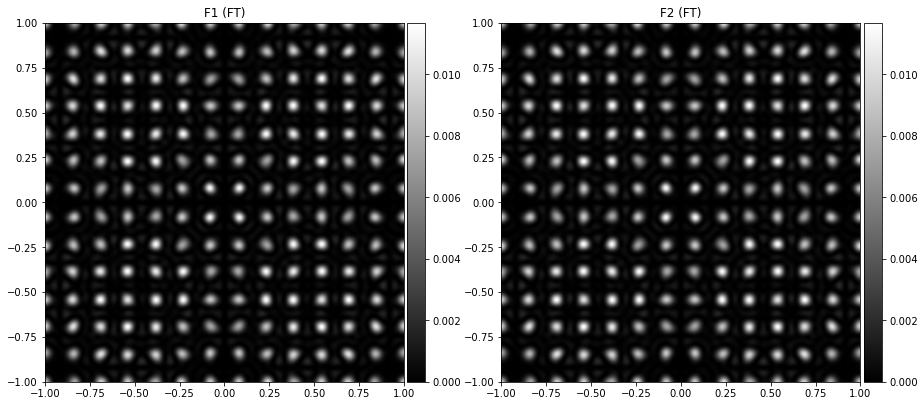

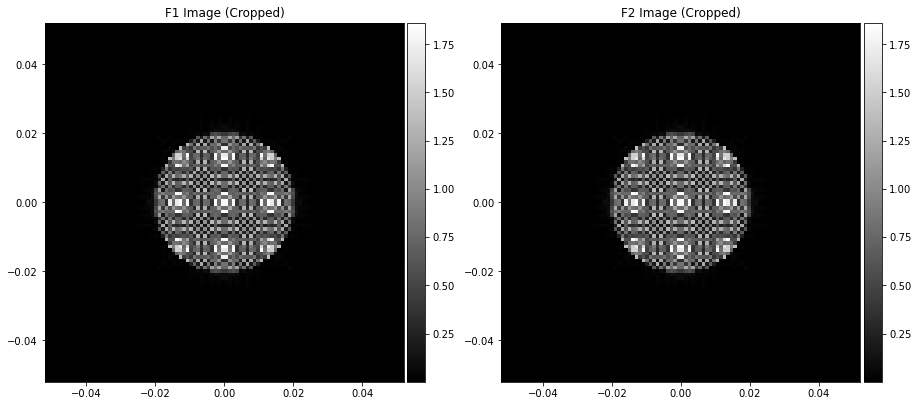

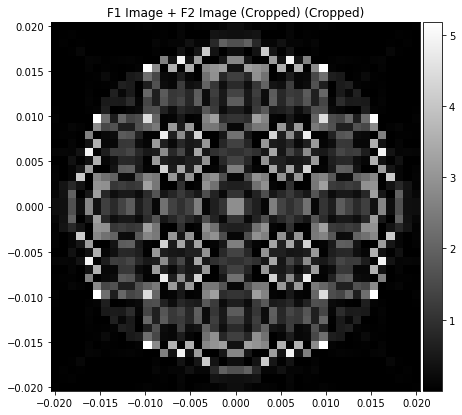

In [37]:
#approximate measurements of parameters in my optical setup.
#I don't notice any interference pattern with these parameters.
bench_measurements = {"wavelength":490e-9, #490nm
                      "length":2.5e-3,#2.5cm #REVERT
                      "z":415e-3, #~415mm
                      "wxp":1.25e-2, #1.25cm
                      "displacement":15e-3 #~15mm
                     }
brooker_bench_measurements = {"wavelength":465e-9, #465nm
                      "length":250e-6,#2.5cm #REVERT
                      "z":273.73e-3, #273.73mm
                      "wxp":1.25e-2, #1.25cm
                      "displacement":10e-3 #~10mm
                     }
bench = BRL_bench_measurements(**bench_measurements, num_points = 1000)
brooker_bench = BRL_bench_measurements(**brooker_bench_measurements, num_points = 1000)
brooker_bench.default_plot()

### Nyquist Sampling Theorem Check
Since the above seems to be a sampling error in `quadratic_phase_prop`, we refer to CFO section 2.1 (p13) to check the Shannon-Nyquist sampling theorem. The theorem states that the Nyquist frequency is the maximum spatial frequency that can be represented in our simulation:
$$
f_{\text{NX}} = \frac{1}{2 \Delta x}
$$
Where $\Delta x$ is the sampling interval. That is: given a number of sample points $M$ and an image plane side length $L$:
$$
\Delta x = \frac{L}{M}
$$
We want to compare this to the spatial frequency of the quadratic phase function, which we can do by taking a derivative of the quadratic phase function:
$$
\frac{d}{dx} e^{\frac{i k}{2 z} (x^2 + y^2)} = \frac{i k x}{z} e^{\frac{i k}{2 z}(x^2 + y^2)}
$$
We can ignore the phase part from the oscillating exponential: so our spatial frequency is approximately:
$$
\frac{k x}{z}
$$

In [59]:
wv_length = 490e-9 #m
k = 2* np.pi / wv_length #m^-1
z = 10e-3 #m
x = 1.25e-2 #m
dx = 2.5e-3/1000 #m
nyquist_freq = 1 / (2*dx) #m^-1
quad_spatial_freq = k * x / z #m^-1
print("wavelength:                               {0:d} nm".format(int(wv_length*1e9)))
print("k:                                        {0:.3e} m^-1".format(k))
print("z displacement:                           {0:.1f} mm".format(z*1e3))
print("maximum x displacement:                   {0:.1f} mm".format(x*1e3))
print("dx:                                       {0:.3e} mm".format(dx*1e3))
print("Spatial frequency at max x displacement:  {0:.3e} m^-1".format(quad_spatial_freq))
print("Nyquist Frequency:                        {0:.3e} m^-1".format(nyquist_freq))

wavelength:                               489 nm
k:                                        1.282e+07 m^-1
z displacement:                           10.0 mm
maximum x displacement:                   12.5 mm
dx:                                       2.500e-03 mm
Spatial frequency at max x displacement:  1.603e+07 m^-1
Nyquist Frequency:                        2.000e+05 m^-1


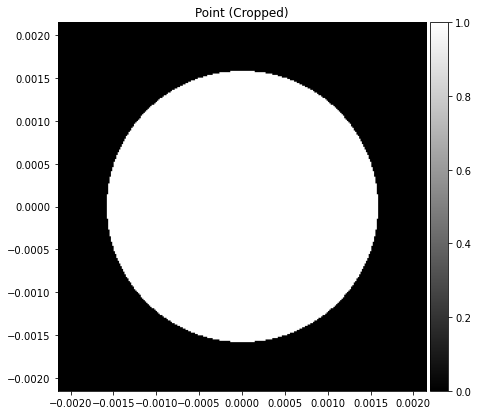

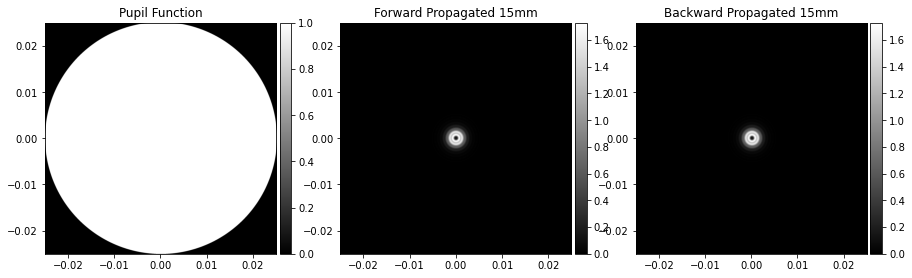

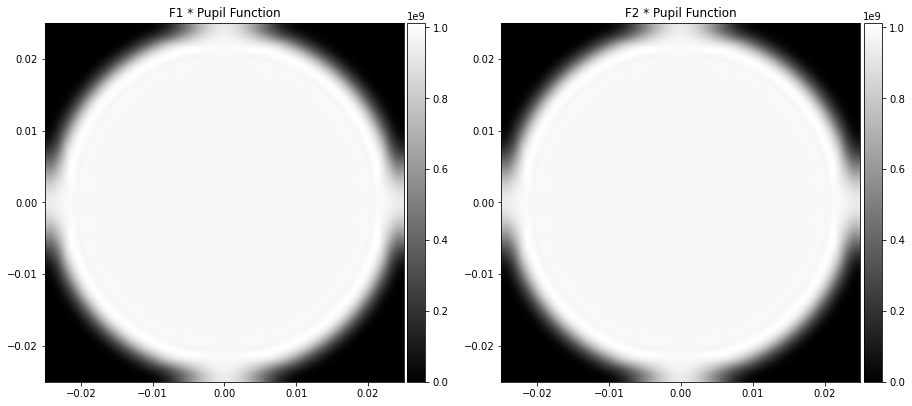

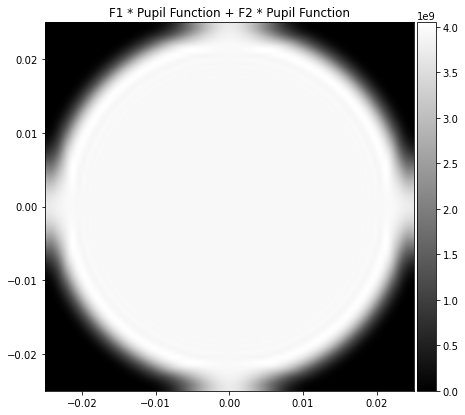

In [21]:
point = image_plane(circ(point_distribution(2000), 0.05), "Point", length = 5e-2)
point.zoom().plot()
#We propagate a constant instead of a dot here for testing purposes. It may be easier to see interference this way.
#generate images F1 and F2. This is done by fresnel propagating a point a displacement d forwards and backwards
p_forward  = fresnel_TF_prop(point, bench_measurements["length"], 
                             bench_measurements["displacement"],
                             wavelength=bench_measurements["wavelength"],
                             label="Forward Propagated 15mm")
p_backward = fresnel_TF_prop(point, bench_measurements["length"],
                             -1*bench_measurements["displacement"],
                             wavelength=bench_measurements["wavelength"],
                             label="Backward Propagated 15mm")
inc_p_forward  = incoherent_image(p_forward, bench_measurements["length"],
                        bench_measurements["z"]-bench_measurements["displacement"],
                        bench_measurements["wxp"], wavelength=bench_measurements["wavelength"],
                        label="Forward Incoherent Image")
inc_p_backward = incoherent_image(p_backward, bench_measurements["length"],
                        bench_measurements["z"]+bench_measurements["displacement"],
                        bench_measurements["wxp"], wavelength=bench_measurements["wavelength"],
                        label="Backward Incoherent Image")

#assume a circular pupil function of diameter 2.5cm
pupil = image_plane(pupil_func(point_distribution(2000), 0.5), label="Pupil Function", length=5e-2)

#our image should then just be the convolution of the pupil function with the object plane F1 and F2
f1_im = convolution(p_forward, pupil, label = "F1 * Pupil Function")
f2_im = convolution(p_backward, pupil, label = "F2 * Pupil Function")
interference = f1_im + f2_im
#plot
plot_images([pupil, p_forward, p_backward])
plot_images([f1_im, f2_im])
interference.plot()

# psf = image_plane((inc_p_forward + inc_p_backward).image, "Point Spread Function")
# #cv = convolution(psf, const, label = "Constant * PSF")
# plot_images([p_forward.zoom(), p_backward.zoom()])
# plot_images([inc_p_forward.zoom(), inc_p_backward.zoom()])
# psf.zoom().plot()
# #plot_images([psf, cv])


In [ ]:
#Plotting Some images with nonphysical parameters to see the interference effects.
p1 = fresnel_TF_prop(point, 1, 0.001, label="Forward Propagated")
p2 = fresnel_TF_prop(point, 1, -0.001, label="Backward Propagated")
plot_images([p1.zoom(),p2.zoom()])
plot_images([point.zoom(), (p1+p2).zoom()])
inc_point = incoherent_image(p1+p2, 1, 1, 5e-6, wavelength=5e-8, label="Incoherent Image")
inc_point.zoom().plot()

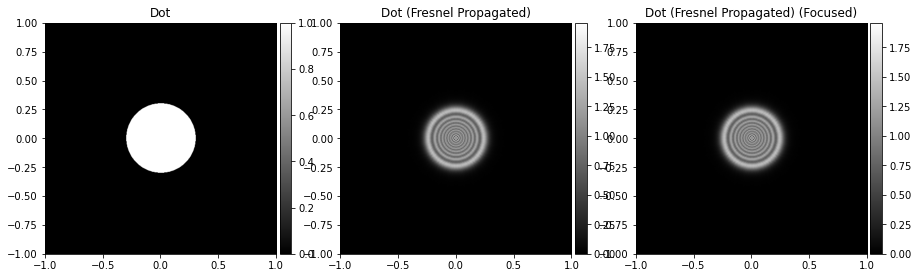

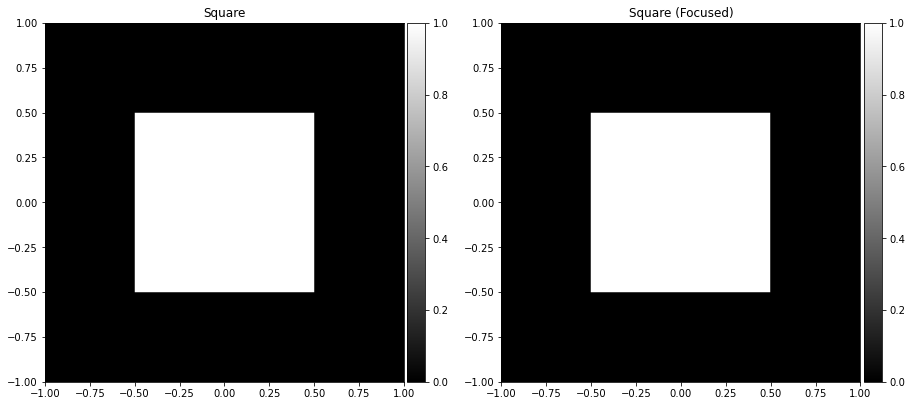

In [7]:
prop = fresnel_TF_prop(dot, 2, 0.005)
foc = focus(prop, 0.5)
plot_images([dot, prop, foc])
plot_images([sq, focus(sq, 0.2)])

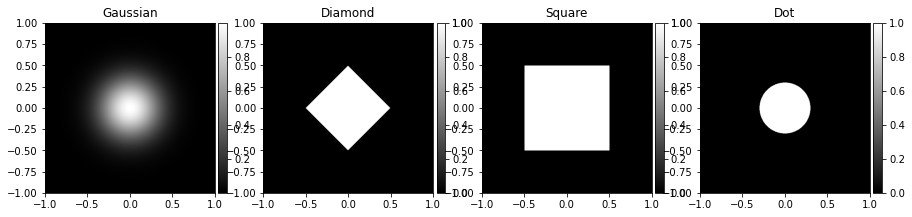

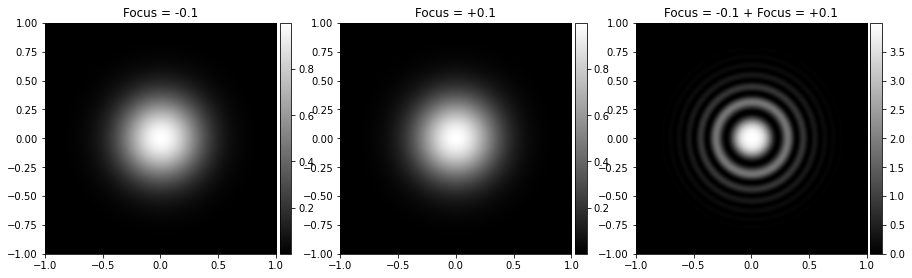

In [8]:
plot_images([gaus, diamond, sq, dot])
f1 = focus(gaus, -0.1, label="Focus = -0.1")
f2 = focus(gaus, 0.1, label="Focus = +0.1")
plot_images([f1, f2, f1+f2])

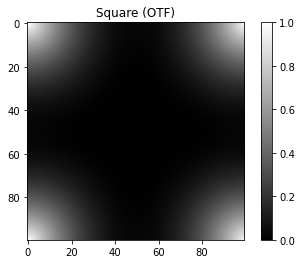

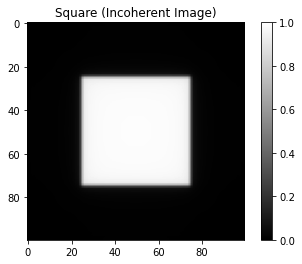

In [56]:
OTF(sq, 0.3, 1, 5e-6, wavelength=5e-8).plot()
incoherent_image(sq, 0.3, 1, 5e-6, wavelength=5e-8).plot()

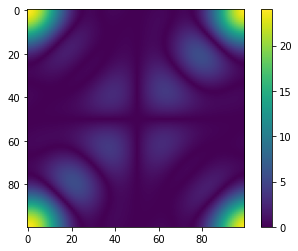

In [37]:
plt.imshow(np.abs(np.real(np.fft.fft2(dot))))
plt.colorbar()

### References
CFO: Computational Fourier Optics: A MATLAB Tutorial

In [17]:
test = (0, 1)
a = [*test, *test]
a

[0, 1, 0, 1]